# Part 4: Basic Machine Learning Models
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: March 23, 2018

## Machine Learning
There are many regulations in place that require insurance ratemaking models to be be interpretable and transparent enough to not conceal any bias against members in the same risk pool. While machine learning models are not frequently used for ratemaking directly, there are other ways insurance companies can use them internally to drive their customer engagement strategy. For simplicity, we'll continue to focus on our auto bodily injury loss data.

Let's load our dataset and split it into training and test sets. The training set is for fitting a model and the test set is for making predictions and accessing the generalization error (how a model predicts outcomes against unseen data). When testing different models and comparing their results, it is common to also include a validation set of data for testing each model's prediction error.

In [1]:
# Load dataset
df <- read.csv("ABI_data.csv")

# Split dataset into training and test sets
train_ind <- sample(nrow(df), size=round(nrow(df)*0.8), replace=FALSE)
x_train <- data.matrix(df[train_ind, 1:6])
x_test <- data.matrix(df[-train_ind, 1:6])
y_train <- df[train_ind, 7]
y_test <- df[-train_ind, 7]

# Print data shapes
cat('Train Data Shape:', dim(x_train), "\n")
cat('Test Data Shape:', dim(x_test))

Train Data Shape: 1071 6 
Test Data Shape: 268 6

## Lasso, Ridge, and ElasticNet Models

#### work in progress

In [2]:
suppressMessages(library(glmnet))

# Fit Lasso, Ridge, and ElasticNet models
lasso <- glmnet(x_train, y_train, family="gaussian", alpha=1)
ridge <- glmnet(x_train, y_train, family="gaussian", alpha=0)
enet <- glmnet(x_train, y_train, family="gaussian", alpha=.5)

In [3]:
# Perform cross-validation on different alphas
lasso_cv <- cv.glmnet(x_train, y_train, type.measure="mse", alpha=1, 
                          family="gaussian")
ridge_cv <- cv.glmnet(x_train, y_train, type.measure="mse", alpha=0,
                          family="gaussian")
enet_cv <- cv.glmnet(x_train, y_train, type.measure="mse", alpha=.5,
                          family="gaussian")

for (i in 0:10) {
  assign(paste("fit", i, sep=""), cv.glmnet(x_train, y_train, type.measure="mse", 
                                            alpha=i/10, family="gaussian"))
}

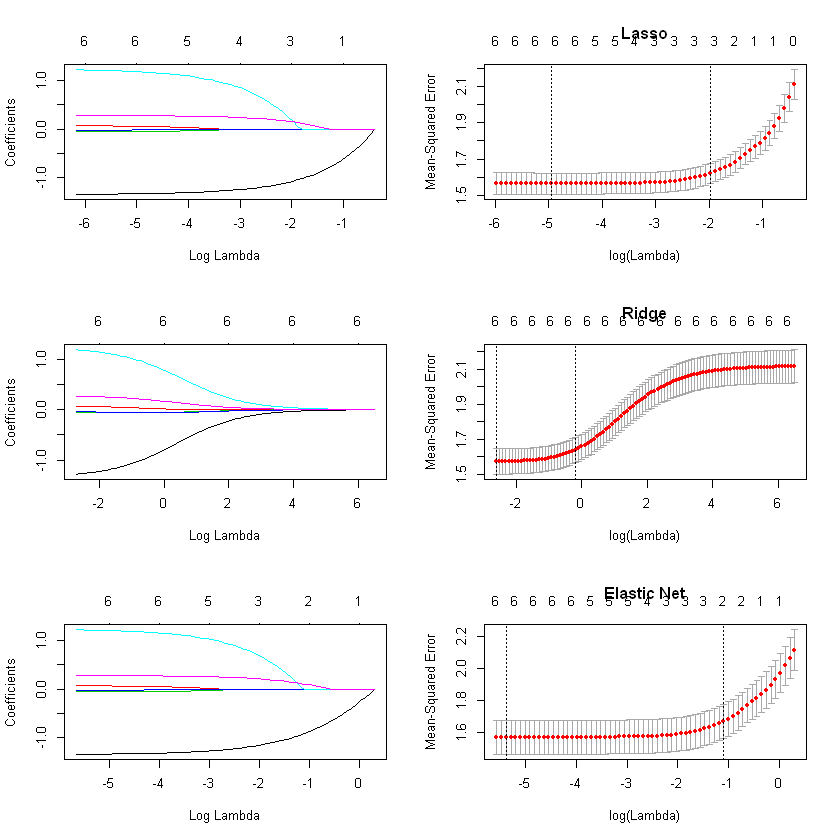

In [4]:
# Plot CV curves
par(mfrow=c(3,2))
plot(lasso, xvar="lambda")
plot(fit10, main="Lasso")

plot(ridge, xvar="lambda")
plot(fit0, main="Ridge")

plot(enet, xvar="lambda")
plot(fit5, main="Elastic Net")

#### Error Rate
We can access how well our models perform by looking at the Root Mean Squared Error (RMSE) between the test outcomes and the model predictions. The formula for RMSE is:

$RMSE = \sqrt{\Sigma^n_{i=1} (X_{obs,i} - X_{model,i})^2/n}$

where $X_{obs}$ is the observed values, $X_{model}$ is modeled values, and $n$ is the number of observations.

In [5]:
suppressWarnings(suppressMessages(library(Metrics)))

# Make model predictions against test set
lasso_preds <- predict(lasso, x_test)
ridge_preds <- predict(ridge, x_test)
enet_preds <- predict(enet, x_test)

# Print RMSE values
paste("Lasso RMSE:", round(rmse(y_test, lasso_preds), 4))
paste("Ridge RMSE:", round(rmse(y_test, ridge_preds), 4))
paste("Elastic Net RMSE:", round(rmse(y_test, enet_preds), 4))

[1] "Lasso RMSE: 1.3165"

[1] "Ridge RMSE: 1.4273"

[1] "Elastic Net RMSE: 1.3221"

## Support Vector Machine (SVM)

#### work in progress

In [6]:
library(e1071)

# Fit linear regression SVM and print summary
svm_model <- svm(TARGET ~ ., data=df, type='eps', kernel='linear')
summary(svm_model)


Call:
svm(formula = TARGET ~ ., data = df, type = "eps", kernel = "linear")


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.1666667 
    epsilon:  0.1 


Number of Support Vectors:  1181






In [7]:
# Tune model parameters with grid-search
svm_tune <- tune('svm', x_train, y_train, ranges = list(gamma = 2^(-1:1), cost = 2^(2:4)),
              tunecontrol = tune.control(sampling = "fix"))

summary(svm_tune)


Parameter tuning of 'svm':

- sampling method: fixed training/validation set 

- best parameters:
 gamma cost
   0.5    4

- best performance: 1.686928 

- Detailed performance results:
  gamma cost    error dispersion
1   0.5    4 1.686928         NA
2   1.0    4 1.725708         NA
3   2.0    4 1.738445         NA
4   0.5    8 1.749010         NA
5   1.0    8 1.754758         NA
6   2.0    8 1.814011         NA
7   0.5   16 1.828747         NA
8   1.0   16 1.837074         NA
9   2.0   16 1.929779         NA


In [8]:
# Uncomment to plot tuning grid
# plot(svm_tune)

In [9]:
# Make model predictions against test set
svm <- svm(x_train, y_train, cost=4.0, gamma=2.0)
svm_preds <- predict(svm, x_test)
paste("SVM RMSE:", round(rmse(y_test, svm_preds), 4))

[1] "SVM RMSE: 1.3641"

## Decision Tree Model

#### work in progress

In [10]:
library(rpart)

# Fit regression tree to data
cntrl <- rpart.control(maxdepth = 10)
dtree <- rpart(TARGET ~ ., data=df, method="anova", control = cntrl)
summary(dtree)

Call:
rpart(formula = TARGET ~ ., data = df, method = "anova", control = cntrl)
  n= 1339 

          CP nsplit rel error    xerror       xstd
1 0.23097930      0 1.0000000 1.0028106 0.04503914
2 0.06746930      1 0.7690207 0.7720079 0.03630326
3 0.01755805      2 0.7015514 0.7091210 0.03268108
4 0.01000000      3 0.6839933 0.6948136 0.03215533

Variable importance
   ATTORNEY NORM_CLMAGE      CLMSEX 
         69          27           4 

Node number 1: 1339 observations,    complexity param=0.2309793
  mean=0.5519552, MSE=2.155151 
  left son=2 (655 obs) right son=3 (684 obs)
  Primary splits:
      ATTORNEY    < 1.5      to the right, improve=0.230979300, (0 missing)
      NORM_CLMAGE < -1.18739 to the left,  improve=0.070969290, (0 missing)
      MARITAL     < 1.5      to the right, improve=0.017497220, (0 missing)
      SEATBELT    < 1.5      to the left,  improve=0.012211220, (0 missing)
      CLMINSUR    < 1.5      to the right, improve=0.001072072, (0 missing)
  Surrogate splits

In [11]:
# Print tree structure
print(dtree)

n= 1339 

node), split, n, deviance, yval
      * denotes terminal node

1) root 1339 2885.74800  0.55195520  
  2) ATTORNEY>=1.5 655 1190.55600 -0.16904070  
    4) NORM_CLMAGE< -1.18739 53   71.77796 -1.10640200 *
    5) NORM_CLMAGE>=-1.18739 602 1068.11000 -0.08651556 *
  3) ATTORNEY< 1.5 684 1028.64300  1.24238300  
    6) NORM_CLMAGE< -1.18739 68  146.93390 -0.36341240 *
    7) NORM_CLMAGE>=-1.18739 616  687.01000  1.41964600 *


In [12]:
# Uncomment lines below to plot tree structure
# plot(dtree)
# text(dtree)

# Uncomment lines below to plot root node error
# par(mfrow=c(2, 1))
# rsq.rpart(dtree)

In [13]:
# Make model predictions against test set
dtree_preds <- predict(dtree, data.frame(x_test))
paste("Decision Tree RMSE:", round(rmse(y_test, dtree_preds), 4))

[1] "Decision Tree RMSE: 1.2487"

## Sources
